In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#__Bird Species: dataset visualization__
Download the dataset from the following link:

- [Bird Species Dataset](https://analytics.drake.edu/~reza/teaching/cs167_fall24/dataset/bird_species_v1.zip)
  - Each image size: __WxHx3__
    - Note these are color images
  
<!--div>
<img src="https://analytics.drake.edu/~reza/teaching/cs167_fall23/notes/images/cifar-10-sprite.png" width=500/>
</div-->


In [ ]:
import os
import cv2
import torch
import matplotlib.pyplot as plt
import pdb
root_dir                    = "/content/drive/MyDrive/cs167_fall24/datasets/bird_species_v1/train/"
name_of_the_bird_species    = os.listdir(root_dir)
if '.DS_Store' in name_of_the_bird_species:
  name_of_the_bird_species.remove('.DS_Store')

name_of_the_bird_species.sort()
sample_images = {}

print("Selected bird species for image recognition are as follows: ")
print("-------------------------------------------------------------------------")
for i in range(len(name_of_the_bird_species)):
  # select a random training image
  all_image_names_cur_species = os.listdir(root_dir + "/" + name_of_the_bird_species[i])
  random_index = torch.randint(len(all_image_names_cur_species), size=(1,)).item()
  img = cv2.imread(root_dir + "/" + name_of_the_bird_species[i] + "/" + all_image_names_cur_species[random_index])
  sample_images[name_of_the_bird_species[i]] = {'img':img, 'train_size':len(all_image_names_cur_species)}

  # display the name of the species
  print(f"{i+1:2}. {name_of_the_bird_species[i]:>25}: {len(all_image_names_cur_species):>20} training samples")

print("-------------------------------------------------------------------------")

Selected bird species for image recognition are as follows: 
-------------------------------------------------------------------------
 1.           ABBOTTS BABBLER:                   50 training samples
 2.         AMETHYST WOODSTAR:                   50 training samples
 3.        ASIAN CRESTED IBIS:                   50 training samples
 4.                 AZURE JAY:                   50 training samples
 5.              BARN SWALLOW:                   50 training samples
 6.         BELTED KINGFISHER:                   50 training samples
 7.                 CASSOWARY:                   50 training samples
 8.        CHINESE POND HERON:                   50 training samples
 9.           CHUCAO TAPACULO:                   50 training samples
10.  CREAM COLORED WOODPECKER:                   50 training samples
11.          CRESTED FIREBACK:                   50 training samples
12.           CRIMSON SUNBIRD:                   50 training samples
13.         DALMATIAN PELICAN:       

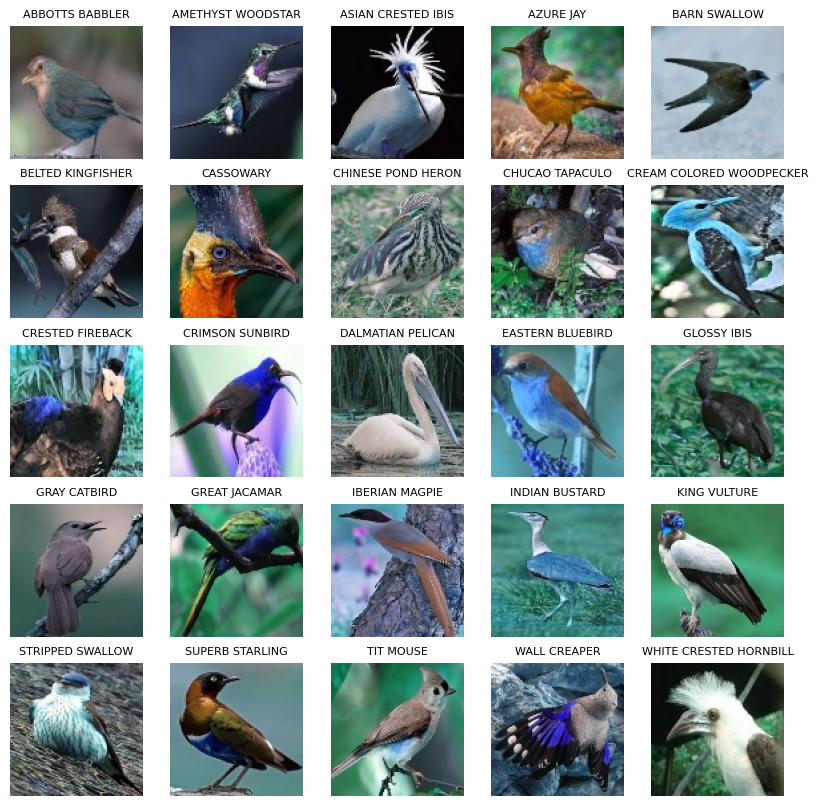

In [ ]:
# showing some sample training images
figure = plt.figure(figsize=(10, 10))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
  #pdb.set_trace()
  cur_sample = sample_images[name_of_the_bird_species[i-1]]
  img   = cur_sample['img']
  label = name_of_the_bird_species[i-1]
  figure.add_subplot(rows, cols, i)
  plt.title(label, fontsize=8)
  plt.axis("off")
  #print('image tensor size:', img.shape)
  plt.imshow(img)
plt.show()


In [ ]:
# CNN networks preparation for fine-tuning:
#     1) AlexNet
#     2) VGGNet
#     3) ResNet
#-----------------------------------------------------------------------------------------------------

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import models
import os
import pdb

class AlexNet(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(AlexNet, self).__init__()
        net = models.alexnet(pretrained=True)

        self.features   = net.features
        self.avgpool    = net.avgpool

        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )


    def forward(self, x):
        #print("shape of input: ", x.shape)
        x = self.features(x)
        #print("output shape (self.features): ", x.shape)
        x = self.avgpool(x)
        #print("output shape (self.avgpool): ", x.shape)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        #print("output shape (self.classifier): ", x.shape)
        return x


class VGGNet(nn.Module):
    def __init__(self, num_classes, pretrained=True, bn=False):
        super(VGGNet, self).__init__()
        net = models.vgg16(pretrained=True)

        self.features = net.features
        self.avgpool = net.avgpool
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )
        #pdb.set_trace()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# 'fine-tuning.'

class ResNet152(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(ResNet152, self).__init__()
        net = models.resnet152(pretrained=True)

        num_features = net.fc.in_features
        net.fc = nn.Linear(num_features, num_classes)

        self.conv1 = net.conv1
        self.bn1 = net.bn1
        self.relu = net.relu
        self.maxpool = net.maxpool

        self.layer1 = net.layer1
        self.layer2 = net.layer2
        self.layer3 = net.layer3
        self.layer4 = net.layer4

        self.avgpool = net.avgpool
        self.fc = net.fc

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x



#__Model 1: AlexNet for fine-tuning and evaluating__

Using cuda device
Size of train set: 1227
Size of test set: 125


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 82.4MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dro

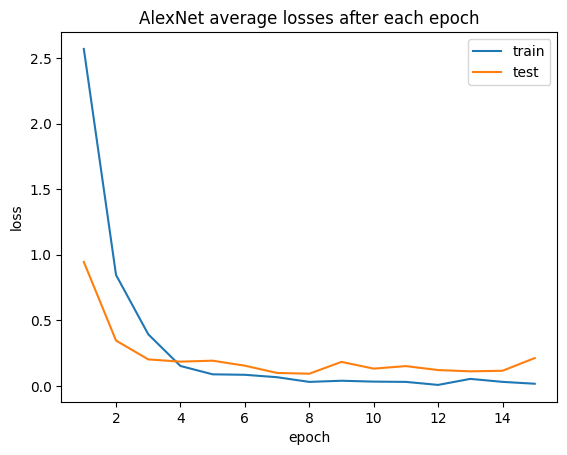

In [ ]:
# Step 1: load the Torch library and other utilities
#----------------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import transforms, datasets
from torchvision import models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas
import time
import numpy as np
import os
import pdb

# check to see if torch.cuda is available, otherwise it will use CPU
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")


# Step 2: load the dataset
#--------------------------------------------------------------------------------------------------
# For fine-tuning with an AlexNet/VGG/ResNet architecture that has been pre-trained using the ImageNet dataset
# each image with the given mean and standard deviation.
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((.229, .224, .225), (.485, .456, .406)) # ImageNet: mean (R, G, B) and standard deviation (R, G, B)
])


train_dir       = "/content/drive/MyDrive/cs167_fall24/datasets/bird_species_v1/train/"
test_dir        = "/content/drive/MyDrive/cs167_fall24/datasets/bird_species_v1/test/"

train_dataset   = datasets.ImageFolder(train_dir, transform=transform) # it loads images from the given directory, subsequently, classes are assigned labels according to the sorted order of the folder names.
test_dataset    = datasets.ImageFolder(test_dir,  transform=transform) # it loads images from the given directory, subsequently, classes are assigned labels according to the sorted order of the folder names.

N_train         = len(train_dataset)
N_test          = len(test_dataset)

number_of_classes = 25

print("Size of train set:", N_train)
print("Size of test set:",  N_test)

# Step 3: Use the AlexNet from above
#--------------------------------------------------------------------------------------------------

class AlexNet(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(AlexNet, self).__init__()
        net = models.alexnet(pretrained=True)

        # retained earlier convolutional and pooling layers from AlexNet
        self.features   = net.features
        self.avgpool    = net.avgpool

        # added new fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )


    def forward(self, x):
        #print("shape of input: ", x.shape)
        x = self.features(x)
        #print("output shape (self.features): ", x.shape)
        x = self.avgpool(x)
        #print("output shape (self.avgpool): ", x.shape)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        #print("output shape (self.classifier): ", x.shape)
        return x

# Step 4: Training and testing functions
#--------------------------------------------------------------------------------------

def train_loop(dataloader, model, loss_fn, optimizer):

    size            = len(dataloader.dataset)
    num_batches     = len(dataloader)

    model.train()

    train_loss      = 0
    correct         = 0
    train_pred_all  = []
    train_y_all     = []

    for batch, (X, y) in enumerate(dataloader):
        # compute prediction and loss

        # ----------- putting data into gpu or sticking to cpu ----------
        X = X.to(device)     # send data to the GPU device (if available)
        y = y.to(device)
        # -----------                                         ----------

        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        # compute the accuracy
        pred_prob   = softmax(pred)
        pred_y 			= torch.max(pred_prob, 1)[1]
        train_correct = (pred_y == y).sum()
        correct    += train_correct.data

        train_pred_all.append(pred_y) # save predicted output for the current batch
        train_y_all.append(y)         # save ground truth for the current batch

    #pdb.set_trace()
    train_pred_all = torch.cat(train_pred_all) # need to concatenate batch-wise appended items
    train_y_all = torch.cat(train_y_all)

    train_loss = train_loss/num_batches
    correct    = correct.cpu().numpy()/size
    return train_loss, correct

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.eval()  # Set model to evaluation mode
    test_loss = 0
    correct = 0

    test_pred_all = []
    test_y_all = []

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            loss = loss_fn(pred, y)
            test_loss += loss.item()

            pred_prob = softmax(pred)
            pred_y = torch.max(pred_prob, 1)[1]
            test_correct = (pred_y == y).sum()
            correct += test_correct.data

            test_pred_all.append(pred_y)
            test_y_all.append(y)

    test_pred_all = torch.cat(test_pred_all)
    test_y_all = torch.cat(test_y_all)

    test_loss = test_loss/num_batches
    correct = correct.cpu().numpy()/size

    conf_matrix = confusion_matrix(test_y_all.cpu(), test_pred_all.cpu())

    return test_loss, correct, conf_matrix

# Step 5: prepare the DataLoader and select optimizer and set the hyper-parameters for learning the model from DataLoader
#------------------------------------------------------------------------------------------------------------------------------

cnn_model = AlexNet(number_of_classes)
cnn_model.to(device)
print(cnn_model)


learning_rate     = 1e-4
batch_size_val    = 32
epochs            = 15
loss_fn           = nn.CrossEntropyLoss()
optimizer         = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)
softmax           = nn.Softmax(dim=1) # for calculating the probability of the network prediction. It is used in train_loop() and test_loop().

train_dataloader  = DataLoader(train_dataset, batch_size=batch_size_val, shuffle=True)  # shuffle the images in training set during fine-tuning
test_dataloader   = DataLoader(test_dataset, batch_size=batch_size_val,  shuffle=False)


train_losses = []
test_losses  = []
train_accuracies = []
test_accuracies = []
start_time = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_train_loss, train_accuracy                    = train_loop(train_dataloader, cnn_model, loss_fn, optimizer)
    avg_test_loss, test_accuracy, conf_matrix_test    = test_loop(test_dataloader,   cnn_model, loss_fn)
    # save the losses and accuracies
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

print("AlexNet model has been fine-tuned!")
print("Total fine-tuning time: %.3f sec" %( (time.time()-start_time)) )
print("Total fine-tuning time: %.3f hrs" %( (time.time()-start_time)/3600) )

# visualizing the loss curves
plt.plot(range(1,epochs+1), train_losses)
plt.plot(range(1,epochs+1), test_losses)
plt.title('AlexNet average losses after each epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()



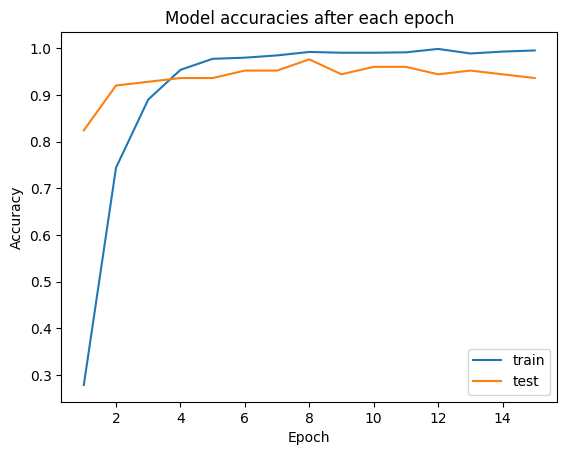

In [ ]:
# visualize the accuracy curves for AlexNet
plt.plot(range(1,epochs+1), train_accuracies)
plt.plot(range(1,epochs+1), test_accuracies)
plt.title('Model accuracies after each epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.show()

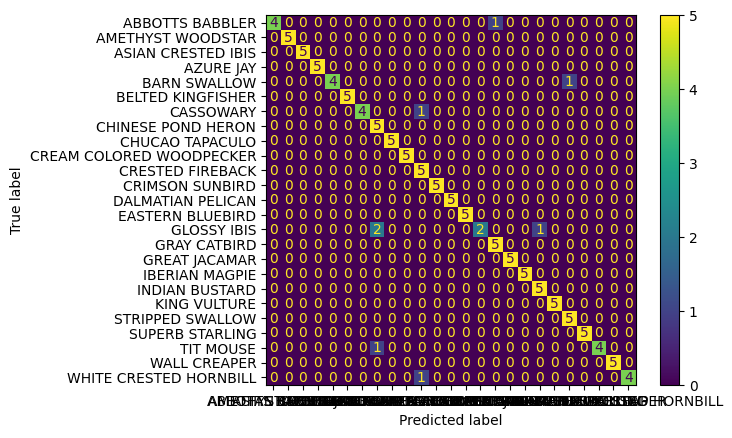

In [ ]:
# visualizing the confusion matrix on the test set after the final epoch
dataset_labels = ['ABBOTTS BABBLER', 'AMETHYST WOODSTAR', 'ASIAN CRESTED IBIS', 'AZURE JAY', 'BARN SWALLOW', 'BELTED KINGFISHER', 'CASSOWARY', 'CHINESE POND HERON', 'CHUCAO TAPACULO', 'CREAM COLORED WOODPECKER', 'CRESTED FIREBACK', 'CRIMSON SUNBIRD', 'DALMATIAN PELICAN', 'EASTERN BLUEBIRD', 'GLOSSY IBIS', 'GRAY CATBIRD', 'GREAT JACAMAR', 'IBERIAN MAGPIE', 'INDIAN BUSTARD', 'KING VULTURE', 'STRIPPED SWALLOW', 'SUPERB STARLING', 'TIT MOUSE', 'WALL CREAPER', 'WHITE CRESTED HORNBILL']

# option #2: prettify
displ = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=dataset_labels)
displ.plot()
plt.show()

#__Model 2: VGGNet for fine-tuning and evaluating__

Using cuda device
Size of train set: 1227
Size of test set: 125


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 74.3MB/s]


VGGNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

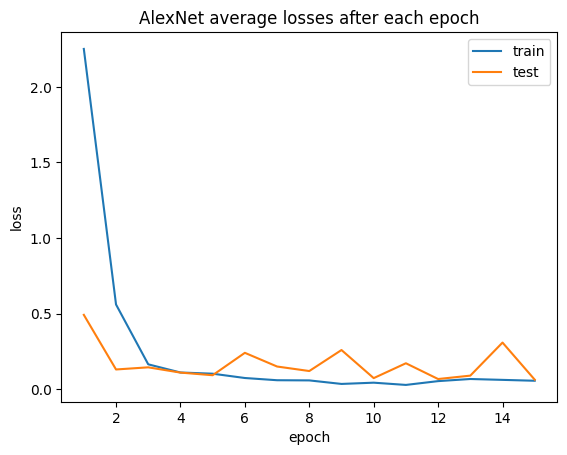

In [ ]:
# Step 1: load the Torch library and other utilities
#----------------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import transforms, datasets
from torchvision import models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas
import time
import numpy as np
import os
import pdb

# check to see if torch.cuda is available, otherwise it will use CPU
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")


# Step 2: load the dataset
#--------------------------------------------------------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((.229, .224, .225), (.485, .456, .406)) # ImageNet: mean (R, G, B) and standard deviation (R, G, B)
])


train_dir       = "/content/drive/MyDrive/cs167_fall24/datasets/bird_species_v1/train/"
test_dir        = "/content/drive/MyDrive/cs167_fall24/datasets/bird_species_v1/test/"

train_dataset   = datasets.ImageFolder(train_dir, transform=transform) # it loads images from the given directory, subsequently, classes are assigned labels according to the sorted order of the folder names.
test_dataset    = datasets.ImageFolder(test_dir,  transform=transform) # it loads images from the given directory, subsequently, classes are assigned labels according to the sorted order of the folder names.

N_train         = len(train_dataset)
N_test          = len(test_dataset)

number_of_classes = 25
print("Size of train set:", N_train)
print("Size of test set:",  N_test)

# Step 3: Use the VGG from above
#--------------------------------------------------------------------------------------------------


class VGGNet(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(VGGNet, self).__init__()
        net = models.vgg16(pretrained=True)
        self.features = net.features
        self.avgpool = net.avgpool
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


    def forward(self, x):
        #print("shape of input: ", x.shape)
        x = self.features(x)
        #print("output shape (self.features): ", x.shape)
        x = self.avgpool(x)
        #print("output shape (self.avgpool): ", x.shape)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        #print("output shape (self.classifier): ", x.shape)
        return x

# Step 4: Training and testing functions
#--------------------------------------------------------------------------------------

def train_loop(dataloader, model, loss_fn, optimizer):

    size            = len(dataloader.dataset)
    num_batches     = len(dataloader)

    model.train()

    train_loss      = 0
    correct         = 0
    train_pred_all  = []
    train_y_all     = []

    for batch, (X, y) in enumerate(dataloader):
        # compute prediction and loss

        # ----------- putting data into gpu or sticking to cpu ----------
        X = X.to(device)     # send data to the GPU device (if available)
        y = y.to(device)
        # -----------                                         ----------

        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        # compute the accuracy
        pred_prob   = softmax(pred)
        pred_y 			= torch.max(pred_prob, 1)[1]
        train_correct = (pred_y == y).sum()
        correct    += train_correct.data

        train_pred_all.append(pred_y) # save predicted output for the current batch
        train_y_all.append(y)         # save ground truth for the current batch

    #pdb.set_trace()
    train_pred_all = torch.cat(train_pred_all) # need to concatenate batch-wise appended items
    train_y_all = torch.cat(train_y_all)

    train_loss = train_loss/num_batches
    correct    = correct.cpu().numpy()/size
    return train_loss, correct

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.eval()  # Set model to evaluation mode
    test_loss = 0
    correct = 0

    test_pred_all = []
    test_y_all = []

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            loss = loss_fn(pred, y)
            test_loss += loss.item()

            pred_prob = softmax(pred)
            pred_y = torch.max(pred_prob, 1)[1]
            test_correct = (pred_y == y).sum()
            correct += test_correct.data

            test_pred_all.append(pred_y)
            test_y_all.append(y)

    test_pred_all = torch.cat(test_pred_all)
    test_y_all = torch.cat(test_y_all)

    test_loss = test_loss/num_batches
    correct = correct.cpu().numpy()/size

    conf_matrix = confusion_matrix(test_y_all.cpu(), test_pred_all.cpu())

    return test_loss, correct, conf_matrix

# Step 5: prepare the DataLoader and select optimizer and set the hyper-parameters for learning the model from DataLoader
#------------------------------------------------------------------------------------------------------------------------------

cnn_model = VGGNet(number_of_classes)
cnn_model.to(device)
print(cnn_model)


learning_rate     = 1e-4
batch_size_val    = 32
epochs            = 15
loss_fn           = nn.CrossEntropyLoss()
optimizer         = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)
softmax           = nn.Softmax(dim=1) # for calculating the probability of the network prediction. It is used in train_loop() and test_loop().

train_dataloader  = DataLoader(train_dataset, batch_size=batch_size_val, shuffle=True)  # shuffle the images in training set during fine-tuning
test_dataloader   = DataLoader(test_dataset, batch_size=batch_size_val,  shuffle=False)

train_losses = []
test_losses  = []
train_accuracies = []
test_accuracies = []
start_time = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_train_loss, train_accuracy                    = train_loop(train_dataloader, cnn_model, loss_fn, optimizer)
    avg_test_loss, test_accuracy, conf_matrix_test    = test_loop(test_dataloader,   cnn_model, loss_fn)
    # save the losses and accuracies
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

print("VGG model has been fine-tuned!")
print("Total fine-tuning time: %.3f sec" %( (time.time()-start_time)) )
print("Total fine-tuning time: %.3f hrs" %( (time.time()-start_time)/3600) )

# visualizing the loss curves
plt.plot(range(1,epochs+1), train_losses)
plt.plot(range(1,epochs+1), test_losses)
plt.title('VGG average losses after each epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()



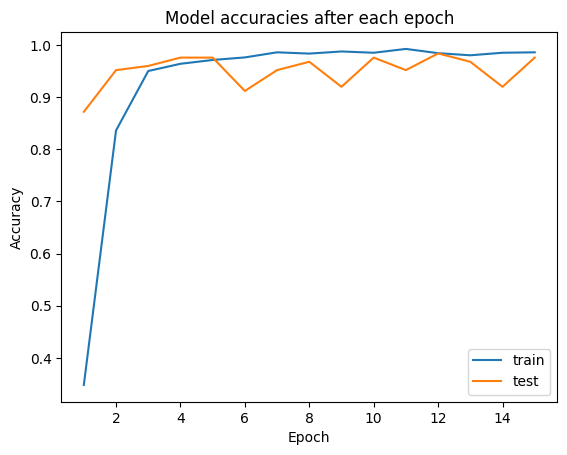

In [ ]:
# visualize the accuracy curves for VGG
plt.plot(range(1,epochs+1), train_accuracies)
plt.plot(range(1,epochs+1), test_accuracies)
plt.title('Model accuracies after each epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.show()

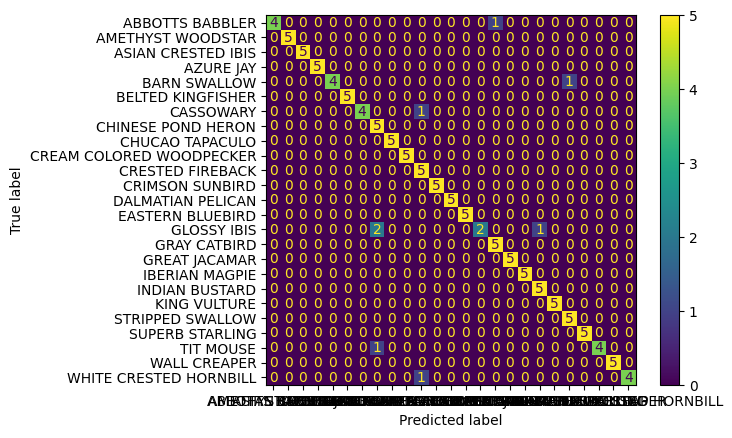

In [ ]:
# visualizing the confusion matrix on the test set after the final epoch
dataset_labels = ['ABBOTTS BABBLER', 'AMETHYST WOODSTAR', 'ASIAN CRESTED IBIS', 'AZURE JAY', 'BARN SWALLOW', 'BELTED KINGFISHER', 'CASSOWARY', 'CHINESE POND HERON', 'CHUCAO TAPACULO', 'CREAM COLORED WOODPECKER', 'CRESTED FIREBACK', 'CRIMSON SUNBIRD', 'DALMATIAN PELICAN', 'EASTERN BLUEBIRD', 'GLOSSY IBIS', 'GRAY CATBIRD', 'GREAT JACAMAR', 'IBERIAN MAGPIE', 'INDIAN BUSTARD', 'KING VULTURE', 'STRIPPED SWALLOW', 'SUPERB STARLING', 'TIT MOUSE', 'WALL CREAPER', 'WHITE CRESTED HORNBILL']


# option #2: prettify
displ = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=dataset_labels)
displ.plot()
plt.show()

#__Model 3: ResNet for fine-tuning and evaluating__

Using cuda device
Size of train set: 1227
Size of test set: 125


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 167MB/s]


ResNet152(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(

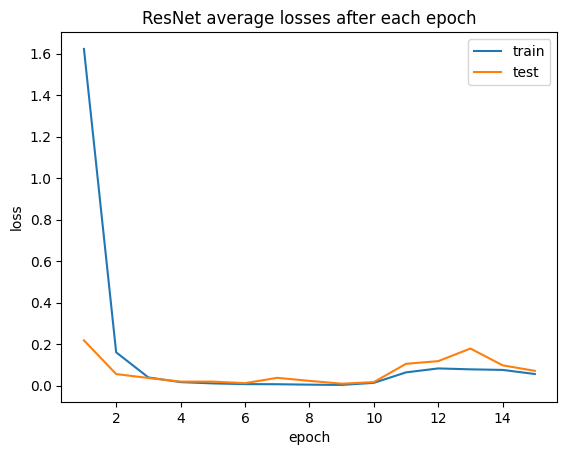

In [ ]:
# Step 1: load the Torch library and other utilities
#----------------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import transforms, datasets
from torchvision import models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas
import time
import numpy as np
import os
import pdb

# check to see if torch.cuda is available, otherwise it will use CPU
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")


# Step 2: load the dataset
#--------------------------------------------------------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((.229, .224, .225), (.485, .456, .406)) # ImageNet: mean (R, G, B) and standard deviation (R, G, B)
])


train_dir       = "/content/drive/MyDrive/cs167_fall24/datasets/bird_species_v1/train/"
test_dir        = "/content/drive/MyDrive/cs167_fall24/datasets/bird_species_v1/test/"

train_dataset   = datasets.ImageFolder(train_dir, transform=transform) # it loads images from the given directory, subsequently, classes are assigned labels according to the sorted order of the folder names.
test_dataset    = datasets.ImageFolder(test_dir,  transform=transform) # it loads images from the given directory, subsequently, classes are assigned labels according to the sorted order of the folder names.

N_train         = len(train_dataset)
N_test          = len(test_dataset)

number_of_classes = 25
print("Size of train set:", N_train)
print("Size of test set:",  N_test)

# Step 3: Use the VGG from above
#--------------------------------------------------------------------------------------------------



class ResNet152(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(ResNet152, self).__init__()
        net = models.resnet152(pretrained=True)

        num_features = net.fc.in_features
        net.fc = nn.Linear(num_features, num_classes)

        self.conv1 = net.conv1
        self.bn1 = net.bn1
        self.relu = net.relu
        self.maxpool = net.maxpool

        self.layer1 = net.layer1
        self.layer2 = net.layer2
        self.layer3 = net.layer3
        self.layer4 = net.layer4

        self.avgpool = net.avgpool
        self.fc = net.fc

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# Step 4: Training and testing functions
#--------------------------------------------------------------------------------------

def train_loop(dataloader, model, loss_fn, optimizer):

    size            = len(dataloader.dataset)
    num_batches     = len(dataloader)

    model.train()                   # set the model to training mode for best practices

    train_loss      = 0
    correct         = 0
    train_pred_all  = []
    train_y_all     = []

    for batch, (X, y) in enumerate(dataloader):
        # compute prediction and loss

        # ----------- putting data into gpu or sticking to cpu ----------
        X = X.to(device)     # send data to the GPU device (if available)
        y = y.to(device)
        # -----------                                         ----------

        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        # compute the accuracy
        pred_prob   = softmax(pred)
        pred_y 			= torch.max(pred_prob, 1)[1]
        train_correct = (pred_y == y).sum()
        correct    += train_correct.data

        train_pred_all.append(pred_y) # save predicted output for the current batch
        train_y_all.append(y)         # save ground truth for the current batch

    #pdb.set_trace()
    train_pred_all = torch.cat(train_pred_all) # need to concatenate batch-wise appended items
    train_y_all = torch.cat(train_y_all)

    train_loss = train_loss/num_batches
    correct    = correct.cpu().numpy()/size
    return train_loss, correct

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.eval()  # Set model to evaluation mode
    test_loss = 0
    correct = 0

    test_pred_all = []
    test_y_all = []

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            loss = loss_fn(pred, y)
            test_loss += loss.item()

            pred_prob = softmax(pred)
            pred_y = torch.max(pred_prob, 1)[1]
            test_correct = (pred_y == y).sum()
            correct += test_correct.data

            test_pred_all.append(pred_y)
            test_y_all.append(y)

    test_pred_all = torch.cat(test_pred_all)
    test_y_all = torch.cat(test_y_all)

    test_loss = test_loss/num_batches
    correct = correct.cpu().numpy()/size

    conf_matrix = confusion_matrix(test_y_all.cpu(), test_pred_all.cpu())

    return test_loss, correct, conf_matrix

# Step 5: prepare the DataLoader and select optimizer and set the hyper-parameters for learning the model from DataLoader
#------------------------------------------------------------------------------------------------------------------------------

cnn_model = ResNet152(number_of_classes)
cnn_model.to(device)
print(cnn_model)


learning_rate     = 1e-4
batch_size_val    = 32
epochs            = 15
loss_fn           = nn.CrossEntropyLoss()
optimizer         = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)
softmax           = nn.Softmax(dim=1) # for calculating the probability of the network prediction. It is used in train_loop() and test_loop().

train_dataloader  = DataLoader(train_dataset, batch_size=batch_size_val, shuffle=True)  # shuffle the images in training set during fine-tuning
test_dataloader   = DataLoader(test_dataset, batch_size=batch_size_val,  shuffle=False)

train_losses = []
test_losses  = []
train_accuracies = []
test_accuracies = []
start_time = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_train_loss, train_accuracy                    = train_loop(train_dataloader, cnn_model, loss_fn, optimizer)
    avg_test_loss, test_accuracy, conf_matrix_test    = test_loop(test_dataloader,   cnn_model, loss_fn)
    # save the losses and accuracies
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

print("ResNet model has been fine-tuned!")
print("Total fine-tuning time: %.3f sec" %( (time.time()-start_time)) )
print("Total fine-tuning time: %.3f hrs" %( (time.time()-start_time)/3600) )

# visualizing the loss curves
plt.plot(range(1,epochs+1), train_losses)
plt.plot(range(1,epochs+1), test_losses)
plt.title('ResNet average losses after each epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()



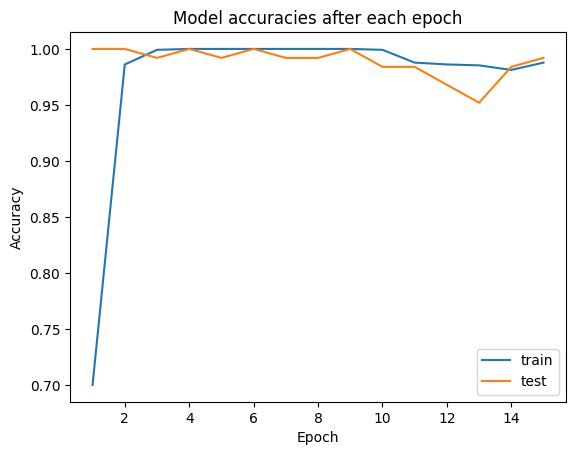

In [ ]:
# visualize the accuracy curves for VGG
plt.plot(range(1,epochs+1), train_accuracies)
plt.plot(range(1,epochs+1), test_accuracies)
plt.title('Model accuracies after each epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.show()

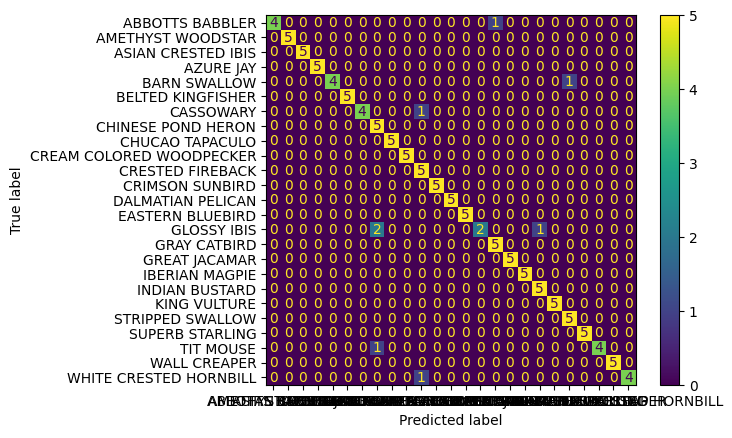

In [ ]:
# visualizing the confusion matrix on the test set after the final epoch
dataset_labels = ['ABBOTTS BABBLER', 'AMETHYST WOODSTAR', 'ASIAN CRESTED IBIS', 'AZURE JAY', 'BARN SWALLOW', 'BELTED KINGFISHER', 'CASSOWARY', 'CHINESE POND HERON', 'CHUCAO TAPACULO', 'CREAM COLORED WOODPECKER', 'CRESTED FIREBACK', 'CRIMSON SUNBIRD', 'DALMATIAN PELICAN', 'EASTERN BLUEBIRD', 'GLOSSY IBIS', 'GRAY CATBIRD', 'GREAT JACAMAR', 'IBERIAN MAGPIE', 'INDIAN BUSTARD', 'KING VULTURE', 'STRIPPED SWALLOW', 'SUPERB STARLING', 'TIT MOUSE', 'WALL CREAPER', 'WHITE CRESTED HORNBILL']

# option #2: prettify
displ = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=dataset_labels)
displ.plot()
plt.show()